In [629]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, explode,substring, length
from pyspark.sql.types import DecimalType
from itertools import cycle
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [630]:
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [631]:
# spark is an custom SparkSession based on some config to work with Jupyter notebooks
iv = spark.read.csv("hdfs://localhost:9000/user/lavish/data/investments.csv"
                , header='true'
                , inferSchema='true')

In [632]:
startYear=1995
endYear=2015

In [633]:
type(iv)

pyspark.sql.dataframe.DataFrame

In [634]:
iv.schema.names

['company_permalink',
 'company_name',
 'company_category_list',
 'company_country_code',
 'company_state_code',
 'company_region',
 'company_city',
 'investor_permalink',
 'investor_name',
 'investor_country_code',
 'investor_state_code',
 'investor_region',
 'investor_city',
 'funding_round_permalink',
 'funding_round_type',
 'funding_round_code',
 'funded_at',
 'raised_amount_usd']

In [635]:
filteredIV = iv.filter(iv.raised_amount_usd.isNotNull())

In [636]:
from pyspark.sql.types import DoubleType
splittedCategoryIV = filteredIV.select('raised_amount_usd',  substring('funded_at',-4,4).cast('int').alias('year')
                       , split(col("company_category_list")
                       , "[|]s*").alias("categoryArr"))

In [637]:
explodedIV=splittedCategoryIV.select('raised_amount_usd','year', explode('categoryArr').alias('category'))

In [638]:
explodedIV.show(10)

+-----------------+----+-----------+
|raised_amount_usd|year|   category|
+-----------------+----+-----------+
|        2000000.0|2008|Curated Web|
|          41250.0|2014|      Games|
|            2.0E7|2015|  Analytics|
|        3000000.0|2013|  Analytics|
|            2.0E7|2015|  Analytics|
|        1700000.0|2013|  Analytics|
|        8900000.0|2014|  Analytics|
|            2.0E7|2015|  Analytics|
|            2.0E7|2015|  Analytics|
|        8900000.0|2014|  Analytics|
+-----------------+----+-----------+
only showing top 10 rows



In [639]:
explodedIV.createOrReplaceTempView("investments")

In [640]:
sqlDF = spark.sql("SELECT * FROM investments")
sqlDF.show()

+-----------------+----+-----------+
|raised_amount_usd|year|   category|
+-----------------+----+-----------+
|        2000000.0|2008|Curated Web|
|          41250.0|2014|      Games|
|            2.0E7|2015|  Analytics|
|        3000000.0|2013|  Analytics|
|            2.0E7|2015|  Analytics|
|        1700000.0|2013|  Analytics|
|        8900000.0|2014|  Analytics|
|            2.0E7|2015|  Analytics|
|            2.0E7|2015|  Analytics|
|        8900000.0|2014|  Analytics|
|        1700000.0|2013|  Analytics|
|        1700000.0|2013|  Analytics|
|        8900000.0|2014|  Analytics|
|        8900000.0|2014|  Analytics|
|        8900000.0|2014|  Analytics|
|        8900000.0|2014|  Analytics|
|         150000.0|2014|     Mobile|
|        1000050.0|2011|     Mobile|
|        1000050.0|2011|     Mobile|
|         150000.0|2014|     Mobile|
+-----------------+----+-----------+
only showing top 20 rows



### Year Wise

In [641]:
SQLQUERY =  """
            SELECT CATEGORY, 
            CAST(YEAR AS INT), 
            SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM INVESTMENTS GROUP 
            BY CATEGORY, YEAR 
            """
#  ORDER BY YEAR DESC, TOTAL DESC

In [642]:
sqlDF = spark.sql(SQLQUERY)
sqlDF.show()

+--------------------+----+-----------------+----------+
|            CATEGORY|YEAR|            TOTAL| TOTAL_DEC|
+--------------------+----+-----------------+----------+
|      Interest Graph|2011|           3.28E7|  32800000|
|           Insurance|2015|  5.70529580149E9|5705295801|
|  Big Data Analytics|2013|     2.35683979E9|2356839790|
|           Aerospace|2014|4.6013734510098E8| 460137345|
|               Audio|2005|          1.058E8| 105800000|
|Cloud Infrastructure|2010|     1.38360796E8| 138360796|
|    Cloud Management|2010|         5.4528E8| 545280000|
|                Apps|2008|   6.3178257004E8| 631782570|
| Insurance Companies|2015|    1.523851749E7|  15238517|
|    Mobile Analytics|2010|          4.205E7|  42050000|
|          Networking|2009|     5.39435025E8| 539435025|
|               Local|2010|     1.50161942E8| 150161942|
|Information Techn...|2000|     6.25112115E8| 625112115|
|       Home & Garden|2007|         5.0605E8| 506050000|
|        Ad Targeting|2010|    

### Total

In [643]:
SQLQUERY =  """
            SELECT CATEGORY, SUM(RAISED_AMOUNT_USD) AS TOTAL, 
            CAST(SUM(RAISED_AMOUNT_USD) AS DECIMAL(30)) AS TOTAL_DEC 
            FROM INVESTMENTS GROUP 
            BY CATEGORY
            ORDER BY TOTAL DESC
            LIMIT 10
            """


In [644]:
sqlDFtop = spark.sql(SQLQUERY)
sqlDFtop.show(10)
categories = sqlDFtop.select('CATEGORY')

+-------------------+--------------------+------------+
|           CATEGORY|               TOTAL|   TOTAL_DEC|
+-------------------+--------------------+------------+
|      Biotechnology|3.004739520880866E11|300473952088|
|           Software|2.542332471829773...|254233247183|
|         E-Commerce|2.012235886316381...|201223588632|
|             Mobile|1.876357592302670...|187635759230|
|Enterprise Software|1.449232704289308...|144923270429|
|        Health Care|1.378121904948731E11|137812190495|
|           Internet|1.118101693513909...|111810169351|
|   Clean Technology|1.060021460000336...|106002146000|
|         Technology|9.471280031366551E10| 94712800314|
|        Advertising|8.465768089987051E10| 84657680900|
+-------------------+--------------------+------------+



In [645]:
topCategories = [row.CATEGORY for row in categories.collect()]
topCategories

['Biotechnology',
 'Software',
 'E-Commerce',
 'Mobile',
 'Enterprise Software',
 'Health Care',
 'Internet',
 'Clean Technology',
 'Technology',
 'Advertising']

In [646]:
topCategoriesDF = sqlDF.filter(col('CATEGORY').isin(topCategories))

In [647]:
sqlDF.dtypes


[('CATEGORY', 'string'),
 ('YEAR', 'int'),
 ('TOTAL', 'double'),
 ('TOTAL_DEC', 'decimal(30,0)')]

In [648]:
topCategoriesDFfrom1995 = topCategoriesDF.filter(col('YEAR') > startYear).sort(col("YEAR").desc())

In [649]:
topCategoriesDFfrom1995.show()

+-------------------+----+--------------------+-----------+
|           CATEGORY|YEAR|               TOTAL|  TOTAL_DEC|
+-------------------+----+--------------------+-----------+
|         E-Commerce|2015|5.922417529146447E10|59224175291|
|      Biotechnology|2015|  4.8271810280071E10|48271810280|
|        Advertising|2015|  9.21792787735302E9| 9217927877|
|           Software|2015|5.194372393718017...|51943723937|
|   Clean Technology|2015|  7.06016861483452E9| 7060168615|
|Enterprise Software|2015|  3.7214521372294E10|37214521372|
|             Mobile|2015|3.031919265541164...|30319192655|
|           Internet|2015|3.116672778818652...|31166727788|
|         Technology|2015|2.133790189752388E10|21337901898|
|        Health Care|2015|2.179298573280523E10|21792985733|
|           Internet|2014|   9.6734957044577E9| 9673495704|
|Enterprise Software|2014| 3.16393701828181E10|31639370183|
|             Mobile|2014| 3.31661064626961E10|33166106463|
|         Technology|2014|1.685184386749

In [650]:
dict = {'Mobile': { 'Y':[0]  , 'T':[1,2]}}
dict['Mobile']['T'][0]

1

In [651]:
dict = {}

for row in topCategoriesDFfrom1995.collect():
    
    if (row.CATEGORY in dict ):
        dict[row.CATEGORY]['Y'].append(row.YEAR)
        dict[row.CATEGORY]['T'].append(row.TOTAL)
    else:
        dict[row.CATEGORY] = { 'Y': [row.YEAR]  , 'T':[row.TOTAL]}
    
    

In [652]:
dict

{'Advertising': {'Y': [2015,
   2014,
   2013,
   2012,
   2011,
   2010,
   2009,
   2008,
   2007,
   2006,
   2005,
   2004,
   2003,
   2002,
   2001,
   2000,
   1999,
   1998,
   1997,
   1996],
  'T': [9217927877.35302,
   8331447033.7875,
   6558997206.5949,
   7685438158.944,
   17158756314.496399,
   5576976705.0,
   2882267816.0,
   5612022722.6947,
   5148850546.0,
   3586820971.0,
   1242930000.0,
   371880000.0,
   9551150000.0,
   145350000.0,
   439615548.0,
   757650000.0,
   240000000.0,
   9000000.0,
   12000000.0,
   2000000.0]},
 'Software': {'Y': [2015,
   2014,
   2013,
   2012,
   2011,
   2010,
   2009,
   2008,
   2007,
   2006,
   2005,
   2004,
   2003,
   2002,
   2001,
   2000,
   1999,
   1998,
   1997],
  'T': [51943723937.180176,
   43872538280.9973,
   25311873888.42697,
   15998191092.237556,
   15148255391.918,
   9621212635.4491,
   7921416648.0,
   12662348503.942005,
   15989260515.081398,
   13386697398.887001,
   12182415519.5279,
   6765924246.

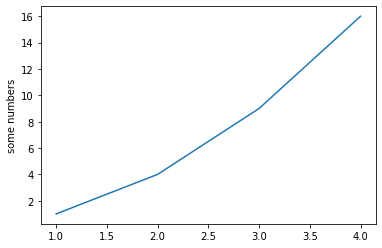

In [653]:

plt.plot([1, 2, 3, 4], [1, 4, 9, 16])
plt.ylabel('some numbers')
plt.show()

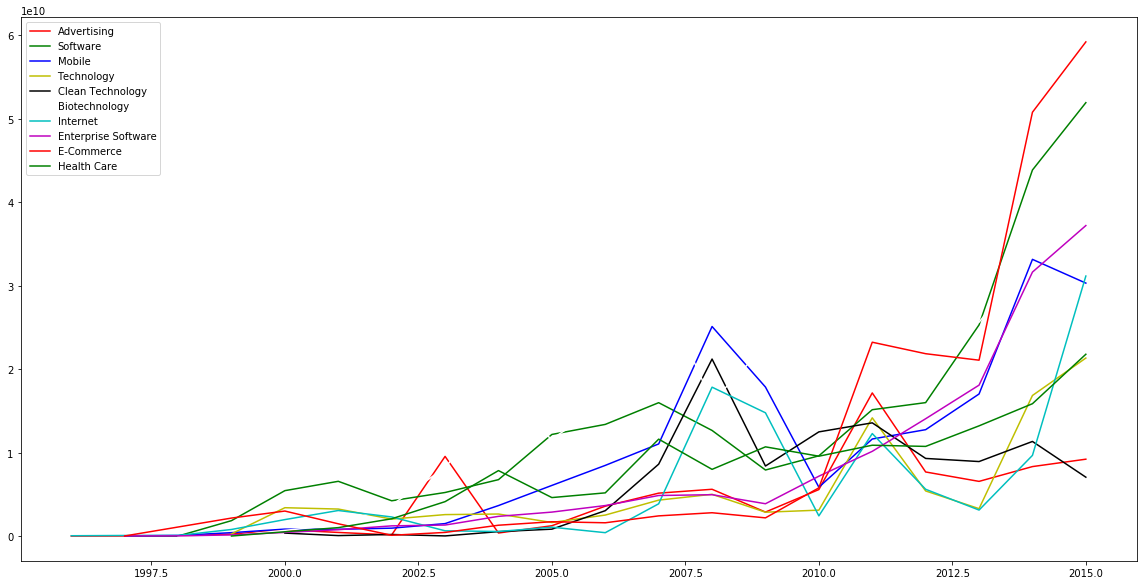

In [654]:
color=cycle('rgbykwcm')
plt.figure(figsize=(20,10))
# evenly sampled time at 200ms intervals

y = np.array(list(range(startYear,endYear)))
z = np.array(list(range(100,120)))
# red dashes, blue squares and green triangles
# d = list(y, y, 'r--', y, y, 'bs', y, y, 'g^'])
for cat,c in zip(dict,color):
    plt.plot(dict[cat]['Y'], dict[cat]['T'], c = c, label = cat)

plt.legend()
plt.show()

In [655]:
t

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4,
       2.6, 2.8, 3. , 3.2, 3.4, 3.6, 3.8, 4. , 4.2, 4.4, 4.6, 4.8])

In [656]:
y

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

In [ ]:
sqlDF.write.mode('overwrite').option("header", "true").csv('hdfs://localhost:9000/user/lavish/data/topcategories.csv')